In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# import atomic.features as fs
# import matplotlib.pyplot as plt
# import pattern.vis as vis
# import sklearn.mixture as mix
# import matplotsoccer as mps
# import atomic.vaep as vaep
# import pattern.action as pat
# import atomic.atomic_spadl as ato
# import pattern.wgmm as wgmm

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [174]:
import numpy as np
from scipy.stats import multivariate_normal, vonmises
from scipy.stats import vonmises
import sklearn.cluster as cluster

class Gauss:
    def fit(self,X,w):
        self.mean = np.average(X,weights=w,axis=0)
        self.covariance = np.cov(X.T,aweights=w)
        return self
    
    def pdf(self,X):
        return multivariate_normal.pdf(X,mean=self.mean,cov=self.covariance)
    
    
class VonMises:
    def fit(self,alpha,w):
        sin = np.average(np.sin(alpha),weights=w,axis=0)
        cos = np.average(np.cos(alpha),weights=w,axis=0)
        
        self.loc = np.arctan2(sin,cos)
        self.R = np.sqrt(sin**2 + cos**2) # mean resultant length
        self.kappa = R * (2 - R**2) / (1 - R**2) # approximation for kappa
        return self
    
    def pdf(self,alpha):
        return vonmises.pdf(alpha,kappa=self.kappa, loc=self.loc).flatten()

class MixtureModel:
    
    def __init__(self,k,distribution = Gauss,max_iter=10,tol=1e-04):
        self.k = k
        self.distribution = distribution
        self.max_iter=max_iter
        self.tol=tol
        
    def fit(self,X,verbose=False):
        weights = self.init_weights(X)
        
        # learn models on initial weights
        self.priors = weights.sum(axis=0)/weights.sum()
        self.submodels = list(self.distribution().fit(X,w) for w in weights.T)
        
        iterations = range(self.max_iter) if not verbose else tqdm.tqdm(range(self.max_iter))
        self.loglikelihood = -np.inf
        for self._n_iter in iterations:
            # Expectation
            for i in range(self.k):
                weights[:,i] = self.priors[i] * self.submodels[i].pdf(X)
                
            # enough improvement or not?
            new_loglikelihood = np.log(weights.sum(axis=1)).sum()
            if new_loglikelihood > self.loglikelihood + self.tol:
                self.loglikelihood = new_loglikelihood
            else:
                break

            # normalize likelihoods such that each data point
            # occurs in the mixture model with P=1
            weights /= weights.sum(axis=1)[:,np.newaxis]

            # Maximalization
            self.priors = weights.sum(axis=0)/weights.sum()
            for i in range(self.k):
                self.submodels[i].fit(X,weights[:,i])

        return self
    
    def init_weights(self,X):
        # initialize weights with KMeans
        n_samples,_ = X.shape
        labels = cluster.KMeans(n_clusters=self.k,n_init=1).fit_predict(X)
        weights = np.zeros((n_samples,self.k))
        weights[np.arange(n_samples), labels] = 1
        return weights
    
    def pdfs(self,X):
        pdfs = np.vstack([m.pdf(X) for m in self.submodels]).T
        return self.priors * pdfs
    
    def likelihoods(self,X):
        return self.pdfs(X).sum(axis=1)
    
    def params(self):
        return list(m.__dict__ for m in self.submodels)

np.set_printoptions(suppress=True)

In [131]:
5**2

25

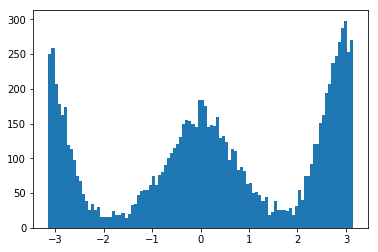

37 -15778.843383062855 [{'loc': array([2.99345122]), 'kappa': array([5.50994696])}, {'loc': array([0.01099996]), 'kappa': array([2.01328951])}]


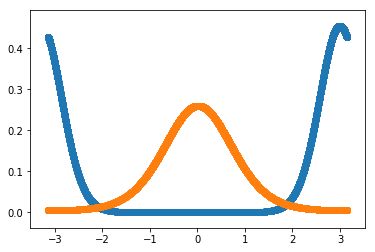

In [173]:
X = np.concatenate([np.random.vonmises(0,2,5000),np.random.vonmises(3,5,5000)]).reshape(-1, 1)
plt.hist(X,bins=100)
plt.show()

model = MixtureModel(k=2,distribution=VonMises,max_iter=100)
model.fit(X)
print(model._n_iter,model.loglikelihood,model.params())

import matplotlib.pyplot as plt
# #hood = model.likelihoods(X)
for pdf in model.pdfs(X).T:
    plt.scatter(X,pdf)
plt.show()

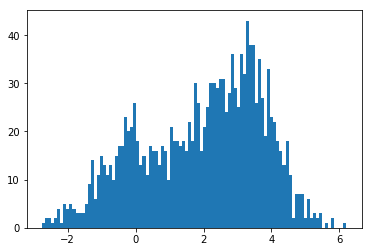

In [126]:
import matplotlib.pyplot as plt

X = np.concatenate([np.random.normal(0,1,500),np.random.normal(3,1,1000)]).reshape(-1, 1)
plt.hist(X,bins=100)
plt.show()

In [129]:
%%time

for i in range(2,3):
    model = MixtureModel(i,max_iter=1000)
    model.fit(X)
    print(i,model._n_iter,model.loglikelihood,model.params())

# import matplotlib.pyplot as plt
# #hood = model.likelihoods(X)
# for pdf in model.pdfs(X).T:
#     plt.scatter(X,pdf)
# plt.show()

2 48 -2877.660207432143 [{'mean': array([3.04367491]), 'covariance': array([[0.96544013]])}, {'mean': array([0.03355804]), 'covariance': array([[1.18152838]])}]
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 91.4 ms


In [128]:
%%time
import sklearn.mixture as mix
model = mix.GaussianMixture(2)
model.fit(X)
model.means_,model.covariances_
model.__dict__

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 13.5 ms


{'n_components': 2,
 'tol': 0.001,
 'reg_covar': 1e-06,
 'max_iter': 100,
 'n_init': 1,
 'init_params': 'kmeans',
 'random_state': None,
 'warm_start': False,
 'verbose': 0,
 'verbose_interval': 10,
 'covariance_type': 'full',
 'weights_init': None,
 'means_init': None,
 'precisions_init': None,
 'converged_': True,
 'weights_': array([0.36729616, 0.63270384]),
 'means_': array([[0.05527034],
        [3.06295014]]),
 'covariances_': array([[[1.18993933]],
 
        [[0.93554226]]]),
 'precisions_cholesky_': array([[[0.91672187]],
 
        [[1.03387562]]]),
 'precisions_': array([[[0.84037898]],
 
        [[1.0688988 ]]]),
 'n_iter_': 3,
 'lower_bound_': -1.9186617876329428}